In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from pycaret.classification import *
import matplotlib as plt

# Libraries
import os

# Used for EDA, Customer profiling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder


from xgboost import XGBClassifier

from scipy import stats
from scipy.stats import randint
from scipy.stats import uniform

In [101]:
data = pd.read_parquet('data_health_score.parquet', engine='pyarrow')
x_months = 8
# Filtrer les clients avec au moins x_months mois de données
data_filtre = data.loc[data.date_start <= '2025-05-01']
data_filtre = data_filtre.groupby('club_id').filter(lambda x: len(x) >= x_months)

# Sélectionnez les x_months derniers mois pour chaque client
data_x_months_derniers_mois = data_filtre.groupby('club_id').tail(x_months)
data_x_months_derniers_mois

clients_stats_list = []
critères = data_x_months_derniers_mois[['login','game_score','attendance','collections','database','message_system','team_message','activation']]

for club_id, groupe in data_x_months_derniers_mois.groupby('club_id'):
    churn_value = groupe['churn'].iloc[-1]  
    mois = np.arange(len(groupe)).reshape(-1, 1)  

    stats_client = {'club_id': club_id, 'churn': churn_value}

    for critère in critères:
        valeurs = groupe[critère].values

        stats_client[f'{critère}_moyenne'] = np.mean(valeurs)
        stats_client[f'{critère}_médiane'] = np.median(valeurs)
        stats_client[f'{critère}_ecart-type'] = np.std(valeurs)

        model = LinearRegression().fit(mois, valeurs)
        stats_client[f'{critère}_pente'] = model.coef_[0]
        stats_client[f'{critère}_amplitude'] = np.max(valeurs)-np.min(valeurs)

    clients_stats_list.append(stats_client)

res = pd.DataFrame(clients_stats_list)
club_static_features = pd.read_excel('clubs_static_features.xlsx')
club_static_features = club_static_features.drop_duplicates(subset='club_id')
res = pd.merge(res, club_static_features, on='club_id', how='left')

renew_jan = pd.read_excel('target_renew_jan_25.xlsx')['club_id']
renew_feb = pd.read_excel('target_renew_feb_25.xlsx')['club_id']
renew_mars = pd.read_excel('target_renew_mars_25.xlsx')['club_id']
renew_apr = pd.read_excel('target_renew_apr_25.xlsx')['club_id']
renew_may = pd.read_excel('target_renew_may_25.xlsx')['club_id']
renew_jun = pd.read_excel('target_renew_june_25.xlsx')['club_id']

In [118]:
res

,club_id,churn,login_moyenne,login_médiane,login_ecart-type,login_pente,login_amplitude,game_score_moyenne,game_score_médiane,game_score_ecart-type,...,team_message_amplitude,activation_moyenne,activation_médiane,activation_ecart-type,activation_pente,activation_amplitude,club_sport_name,club_country_id,club_total_price,club_sales_person_name
0,1,0,1.000,1.0,0.000000,0.000000,0,0.2500,0.20,0.193649,...,0.40,0.93250,0.930,0.010897,-0.002381,0.03,football,FR,"4568,5",Guillaume
1,2,1,1.000,1.0,0.000000,0.000000,0,0.1125,0.10,0.105327,...,0.20,0.00000,0.000,0.000000,0.000000,0.00,volley,FR,"1148,65",Guillaume
2,3,1,0.625,1.0,0.484123,-0.178571,1,0.1125,0.00,0.196453,...,0.00,0.60750,0.810,0.350740,-0.115714,0.81,football,FR,340,Guillaume
3,4,0,1.000,1.0,0.000000,0.000000,0,0.0325,0.00,0.056292,...,0.38,0.94000,0.940,0.000000,0.000000,0.00,football,FR,"4729,6",Guillaume
4,5,0,1.000,1.0,0.000000,0.000000,0,0.6575,0.71,0.067777,...,0.57,0.94375,0.940,0.021176,0.000595,0.07,football,FR,"903,18",Guillaume
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,22378,0,1.000,1.0,0.000000,0.000000,0,0.0425,0.00,0.073612,...,0.50,0.79750,0.840,0.112444,0.028333,0.34,rugby,FR,"289,74",Etienne
4016,22382,0,0.250,0.0,0.433013,-0.095238,1,0.0000,0.00,0.000000,...,0.00,0.85125,0.830,0.056222,-0.014167,0.17,football,FR,396,Séléna
4017,22384,0,1.000,1.0,0.000000,0.000000,0,0.2200,0.23,0.026458,...,0.23,0.92375,0.920,0.004841,-0.000357,0.01,rugby,IT,792,Davide M.
4018,22425,0,1.000,1.0,0.000000,0.000000,0,0.0000,0.00,0.000000,...,0.67,0.98500,0.985,0.005000,-0.001905,0.01,generic,FR,"249,34",Antoine Painault


In [102]:
# new train/test split by quarter
#to_renew = pd.concat([renew_jan,renew_feb, renew_mars], axis=0)
to_renew = renew_jun

In [103]:
# train/test split
X_test = res[res['club_id'].isin(set(to_renew))]
y_test = res[res['club_id'].isin(set(to_renew))].churn

X_train = res[res['club_id'].isin(set(res.club_id) - set(to_renew))]
y_train = res[res['club_id'].isin(set(res.club_id) - set(to_renew))].churn

#X_train = X_train.loc[X_train.club_country_id.isin(['FR','BE','CH'])]
#y_train_aux = res[res['club_id'].isin(set(res.club_id) - set(to_renew))]
#y_train = y_train_aux.loc[y_train_aux.club_country_id.isin(['FR','BE','CH'])].churn

#X_test = X_test.loc[X_train.club_country_id.isin(['FR','BE','CH'])]
#y_test_aux = res[res['club_id'].isin(set(res.club_id) - set(to_renew))]
#y_test = y_test_aux.loc[y_test_aux.club_country_id.isin(['FR','BE','CH'])].churn

# Examine Evaluation Metrics

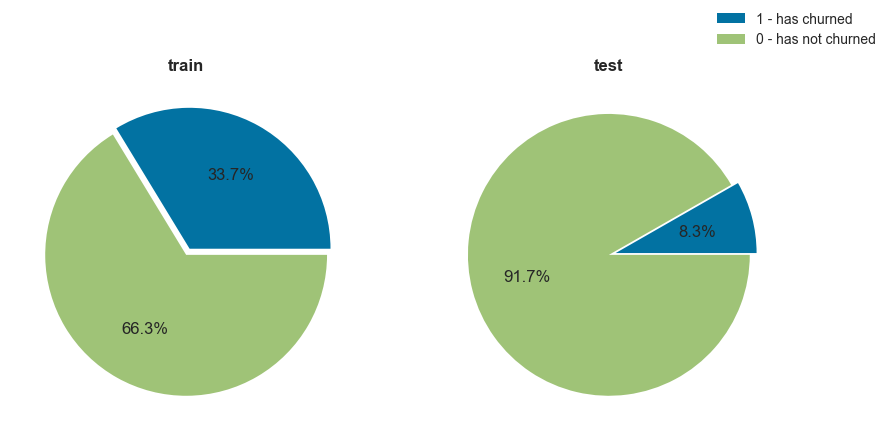

In [104]:
# Balance between train and test dataset
num_churn_train = sum(X_train.churn == 1)
num_churn_test = sum(X_test.churn == 1)
explode = (0.05,0)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.pie([num_churn_train,len(X_train)-num_churn_train], explode=explode, autopct='%1.1f%%',)
ax1.set_title('train', fontweight="bold")

ax2.pie([num_churn_test,len(X_test)-num_churn_test], explode=explode, autopct='%1.1f%%',)
ax2.set_title('test', fontweight="bold")

fig.legend([ax1, ax2], labels=['1 - has churned','0 - has not churned'])

In [483]:
# Change of training dataset
#X_train_churn = X_train.loc[X_train.churn == 1]
#X_train_churn_new = X_train_churn.iloc[::2, :]
#X_train_new = pd.concat([X_train.loc[X_train.churn == 0], X_train_churn_new]).sort_index()
#X_train_new

,club_id,churn,login_moyenne,login_médiane,login_ecart-type,login_pente,login_amplitude,game_score_moyenne,game_score_médiane,game_score_ecart-type,...,team_message_amplitude,activation_moyenne,activation_médiane,activation_ecart-type,activation_pente,activation_amplitude,club_sport_name,club_country_id,club_total_price,club_sales_person_name
0,1,0,1.00,1.0,0.000000,0.000000,0,0.2500,0.20,0.193649,...,0.40,0.93250,0.930,0.010897,-0.002381,0.03,football,FR,"4568,5",Guillaume
1,2,1,1.00,1.0,0.000000,0.000000,0,0.1125,0.10,0.105327,...,0.20,0.00000,0.000,0.000000,0.000000,0.00,volley,FR,"1148,65",Guillaume
3,4,0,1.00,1.0,0.000000,0.000000,0,0.0325,0.00,0.056292,...,0.38,0.94000,0.940,0.000000,0.000000,0.00,football,FR,"4729,6",Guillaume
4,5,0,1.00,1.0,0.000000,0.000000,0,0.6575,0.71,0.067777,...,0.57,0.94375,0.940,0.021176,0.000595,0.07,football,FR,"903,18",Guillaume
5,6,0,1.00,1.0,0.000000,0.000000,0,0.0000,0.00,0.000000,...,0.17,0.97500,0.980,0.008660,0.002857,0.02,rugby,FR,"2194,35",Guillaume
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,22378,0,1.00,1.0,0.000000,0.000000,0,0.0425,0.00,0.073612,...,0.50,0.79750,0.840,0.112444,0.028333,0.34,rugby,FR,"289,74",Etienne
4016,22382,0,0.25,0.0,0.433013,-0.095238,1,0.0000,0.00,0.000000,...,0.00,0.85125,0.830,0.056222,-0.014167,0.17,football,FR,396,Séléna
4017,22384,0,1.00,1.0,0.000000,0.000000,0,0.2200,0.23,0.026458,...,0.23,0.92375,0.920,0.004841,-0.000357,0.01,rugby,IT,792,Davide M.
4018,22425,0,1.00,1.0,0.000000,0.000000,0,0.0000,0.00,0.000000,...,0.67,0.98500,0.985,0.005000,-0.001905,0.01,generic,FR,"249,34",Antoine Painault


In [577]:
#num_churn_train = sum(X_train_new.churn == 1)
#num_churn_test = sum(X_test.churn == 1)
#explode = (0.05,0)

#fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
#ax1.pie([num_churn_train,len(X_train_new)-num_churn_train], explode=explode, autopct='%1.1f%%',)
#ax1.set_title('train', fontweight="bold")

#ax2.pie([num_churn_test,len(X_test)-num_churn_test], explode=explode, autopct='%1.1f%%',)
#ax2.set_title('test', fontweight="bold")

#fig.legend([ax1, ax2], labels=['1 - has churned','0 - has not churned'])

# Model using RandomForest

In [126]:
# traitement des features qualitatives
X_train['country'] = X_train['club_country_id'].apply(lambda x: 1 if x in ['FR', 'CH', 'BE'] else 0)
X_train['sport'] = X_train['club_sport_name'].apply(lambda x: 1 if x in ['football', 'rugby'] else 0)
X_train['price'] = X_train['club_total_price'].apply(lambda x: float(x.replace(',', '.')))

X_test['country'] = X_test['club_country_id'].apply(lambda x: 1 if x in ['FR', 'CH', 'BE'] else 0)
X_test['sport'] = X_test['club_sport_name'].apply(lambda x: 1 if x in ['football', 'rugby'] else 0)
X_test['price'] = X_test['club_total_price'].apply(lambda x: float(x.replace(',', '.')))

X_train_rf = X_train.drop(['club_id','churn','club_sport_name','club_total_price','club_sales_person_name','club_country_id'],axis=1)
X_test_rf = X_test.drop(['club_id','churn','club_sport_name','club_total_price','club_sales_person_name','club_country_id'],axis=1)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       122
           1       0.50      0.45      0.48        11

    accuracy                           0.92       133
   macro avg       0.73      0.71      0.72       133
weighted avg       0.91      0.92      0.92       133

Confusion Matrix:
[[117   5]
 [  6   5]]

Accuracy: 0.9172932330827067
Overall Precision: 0.5
Overall Recall: 0.45454545454545453
Overall f1-score: 0.47619047619047616


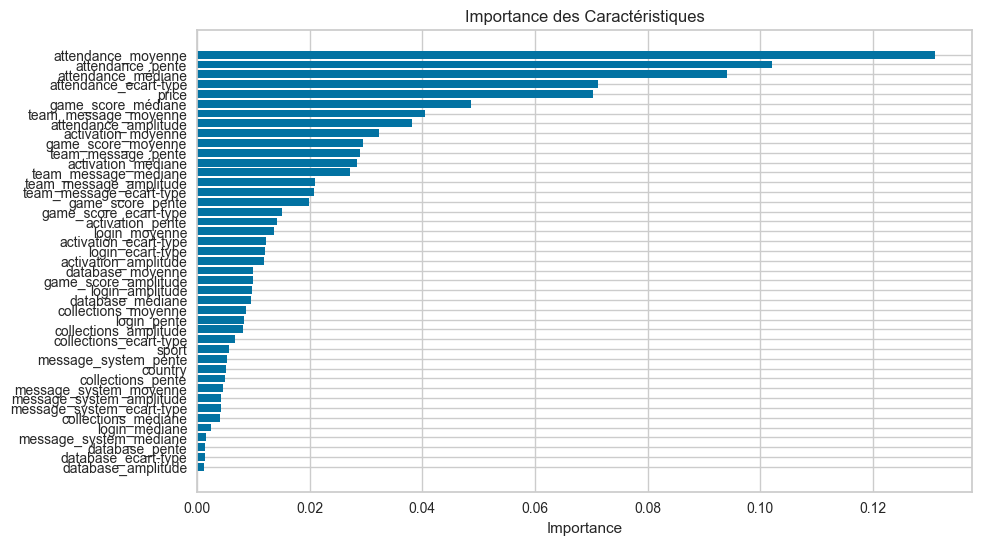

In [111]:
#X_train_rf = X_train.drop(['club_id','churn'],axis=1)
#X_test_rf = X_test.drop(['club_id','churn'],axis=1)

rf = RandomForestClassifier()
rf.fit(X_train_rf, y_train)

rfpred = rf.predict(X_test_rf)
print(classification_report(y_test, rfpred))

ypred = rfpred
model = rf
print ('Confusion Matrix:')
print(confusion_matrix(y_test, ypred))
print('\nAccuracy:', accuracy_score(y_test, ypred))
print("Overall Precision:",precision_score(y_test, ypred))
print("Overall Recall:",recall_score(y_test, ypred))
print("Overall f1-score:", f1_score(y_test, ypred))
auc = roc_auc_score(y_test,ypred)
plt.show()


feature_importances = model.feature_importances_

features = X_train_rf.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Importance des Caractéristiques')
plt.gca().invert_yaxis()  # Inverser pour avoir la caractéristique la plus importante en haut
plt.show()

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=14, min_samples_leaf=3, min_samples_split=4, n_estimators=18; total time=   0.1s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=69; total time=   0.2s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=3, min_samples_split=6, n_estimators=40; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=5, min_samples_split=8, n_estimators=98; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=59; total time=   0.2s
[CV] END bootstrap=False, max_depth=8, min_samples_leaf=2, min_samples_split=7, n_estimators=184; total time=   0.7s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=7, min_samples_split=10, n_estimators=199; total time=   0.5s
[CV] E

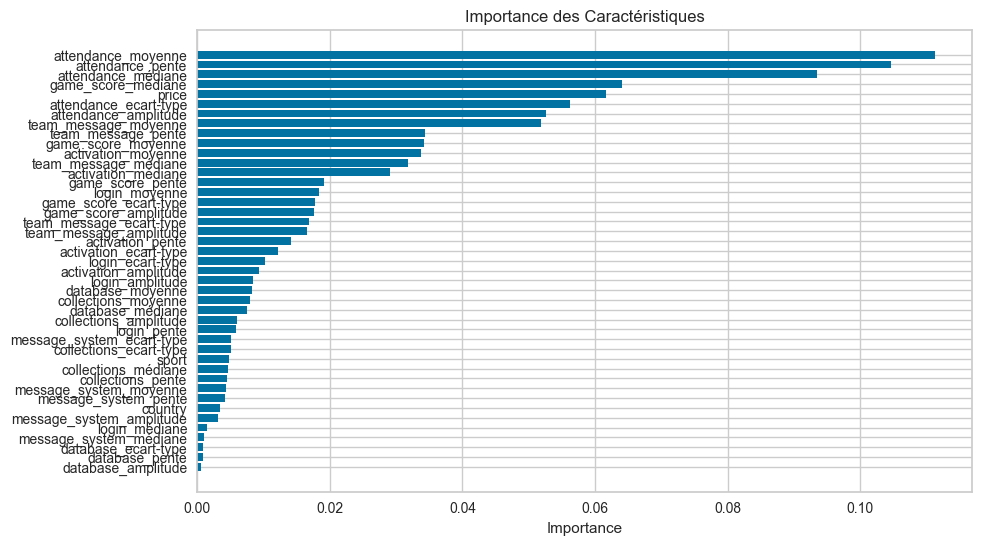

In [114]:
params = {
    'n_estimators': randint(1, 200),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'bootstrap': [True, False]
}
rfnew = RandomForestClassifier()

search = RandomizedSearchCV(rfnew, param_distributions=params, random_state=123, n_iter=100, cv=3, verbose=2, n_jobs=-1)


search.fit(X_train_rf, y_train)
best_params = search.best_params_



myrf = search.best_estimator_
thisypred = myrf.predict(X_test_rf)

print(classification_report(y_test, thisypred))

myrf = RandomForestClassifier(bootstrap=best_params['bootstrap'],
                              max_depth=best_params['max_depth'],
                              min_samples_leaf=best_params['min_samples_leaf'],
                              min_samples_split=best_params['min_samples_split'],
                              n_estimators=best_params['n_estimators'])
myrf.fit(X_train_rf, y_train)
thisypred = myrf.predict(X_test_rf)


ypred = thisypred
model = myrf
print ('Confusion Matrix:')
print(confusion_matrix(y_test, ypred))
print('Accuracy:', accuracy_score(y_test, ypred))
print("Overall Precision:",precision_score(y_test, ypred))
print("Overall Recall:",recall_score(y_test, ypred))
auc = roc_auc_score(y_test,ypred)

print("AUC:", auc)
plt.show()


feature_importances = model.feature_importances_

features = X_train_rf.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Importance des Caractéristiques')
plt.gca().invert_yaxis()  # Inverser pour avoir la caractéristique la plus importante en haut
plt.show()

# Model using PyCaret

In [116]:
s = setup(X_train, target = 'churn', ignore_features = ['club.id'])

# compare all models
best_model = compare_models(sort='F1')

# tune best model
tuned_best_model = tune_model(best_model)

#plot_model(tuned_best_model, plot = 'feature')
# Confusion Matrix
#plot_model(tuned_best_model, plot = 'confusion_matrix')

predict_model(tuned_best_model, raw_score=True, data=X_test)

,Description,Value
0,Session id,3973
1,Target,churn
2,Target type,Binary
3,Original data shape,"(3887, 49)"
4,Transformed data shape,"(3887, 49)"
5,Transformed train set shape,"(2720, 49)"
6,Transformed test set shape,"(1167, 49)"
7,Ignore features,1
8,Numeric features,44
9,Categorical features,4


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8974,0.9545,0.8049,0.8813,0.8410,0.7655,0.7676,0.0280
lr,Logistic Regression,0.8875,0.9491,0.8179,0.8441,0.8305,0.7463,0.7468,0.0290
ridge,Ridge Classifier,0.8824,0.9438,0.7394,0.8941,0.8089,0.7251,0.7323,0.0090
lightgbm,Light Gradient Boosting Machine,0.8551,0.8928,0.8331,0.7654,0.7959,0.6843,0.6878,0.3770
qda,Quadratic Discriminant Analysis,0.8397,0.9015,0.8921,0.7092,0.7899,0.6631,0.6749,0.0090
xgboost,Extreme Gradient Boosting,0.8625,0.9047,0.7687,0.8143,0.7899,0.6879,0.6894,0.0150
lda,Linear Discriminant Analysis,0.8724,0.9391,0.7110,0.8892,0.7895,0.6997,0.7092,0.0100
gbc,Gradient Boosting Classifier,0.8621,0.8989,0.7317,0.8392,0.7798,0.6805,0.6854,0.0980
rf,Random Forest Classifier,0.8592,0.9445,0.6880,0.8699,0.7650,0.6670,0.6786,0.0390
ada,Ada Boost Classifier,0.7978,0.8483,0.7808,0.6758,0.7233,0.5656,0.5705,0.0340


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

[CV] END bootstrap=True, max_depth=14, min_samples_leaf=3, min_samples_split=4, n_estimators=18; total time=   0.1s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=69; total time=   0.2s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=3, min_samples_split=6, n_estimators=40; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=3, min_samples_split=6, n_estimators=40; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=5, min_samples_split=8, n_estimators=98; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=59; total time=   0.1s
[CV] END bootstrap=False, max_depth=8, min_samples_leaf=2, min_samples_split=7, n_estimators=184; total time=   0.7s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=7, min_samples_

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8824,0.9519,0.9231,0.7706,0.8400,0.7482,0.7558
1,0.8750,0.9416,0.8681,0.7822,0.8229,0.7267,0.7291
2,0.8676,0.9154,0.8352,0.7835,0.8085,0.7075,0.7084
3,0.8346,0.9110,0.8152,0.7282,0.7692,0.6409,0.6434
4,0.8493,0.8775,0.8478,0.7429,0.7919,0.6745,0.6781
5,0.9007,0.9542,0.8804,0.8351,0.8571,0.7812,0.7818
6,0.8934,0.9514,0.9022,0.8058,0.8513,0.7686,0.7716
7,0.8824,0.9344,0.8804,0.7941,0.8351,0.7440,0.7464
8,0.8750,0.9174,0.7935,0.8295,0.8111,0.7178,0.7182


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9098,0.9057,0.3636,0.4444,0.4000,0.3517,0.3538


,club_id,login_moyenne,login_médiane,login_ecart-type,login_pente,login_amplitude,game_score_moyenne,game_score_médiane,game_score_ecart-type,game_score_pente,...,club_country_id,club_total_price,club_sales_person_name,country,sport,price,churn,prediction_label,prediction_score_0,prediction_score_1
29,31,1.0,1.0,0.0,0.0,0,0.45875,0.565,0.250222,-0.073214,...,FR,"3011,3",Guillaume,1,0,3011.300049,0,0,0.91,0.09
332,512,1.0,1.0,0.0,0.0,0,0.20750,0.240,0.091754,-0.035000,...,BE,"4276,3",Anciens Stagiaires,1,0,4276.299805,0,0,0.85,0.15
406,691,1.0,1.0,0.0,0.0,0,0.25000,0.280,0.108282,-0.032381,...,FR,"14546,13",Etienne,1,1,14546.129883,0,0,0.95,0.05
526,1139,1.0,1.0,0.0,0.0,0,0.59000,0.785,0.400406,-0.151429,...,BE,"2728,65",Guillaume,1,1,2728.649902,0,0,0.84,0.16
588,1628,1.0,1.0,0.0,0.0,0,0.16000,0.195,0.089022,-0.035952,...,CH,"9492,32",Mathis,1,0,9492.320312,0,0,0.88,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,20230,1.0,1.0,0.0,0.0,0,0.35125,0.315,0.148697,-0.036310,...,FR,"1560,96",Nicolas,1,1,1560.959961,0,0,0.86,0.14
3686,20231,1.0,1.0,0.0,0.0,0,0.29125,0.305,0.077045,0.014405,...,FR,"3839,04",Séléna,1,1,3839.040039,0,0,0.91,0.09
3688,20236,1.0,1.0,0.0,0.0,0,0.23750,0.300,0.099216,0.005952,...,FR,"859,32",Lucas,1,1,859.320007,0,0,0.95,0.05
3692,20267,1.0,1.0,0.0,0.0,0,0.31500,0.315,0.100623,-0.017143,...,FR,"1872,24",Etienne,1,1,1872.239990,0,0,0.89,0.11


In [140]:
corr = X_train_rf.corr()
corr.style.background_gradient(cmap='coolwarm')

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,login_moyenne,login_médiane,login_ecart-type,login_pente,login_amplitude,game_score_moyenne,game_score_médiane,game_score_ecart-type,game_score_pente,game_score_amplitude,attendance_moyenne,attendance_médiane,attendance_ecart-type,attendance_pente,attendance_amplitude,collections_moyenne,collections_médiane,collections_ecart-type,collections_pente,collections_amplitude,database_moyenne,database_médiane,database_ecart-type,database_pente,database_amplitude,message_system_moyenne,message_system_médiane,message_system_ecart-type,message_system_pente,message_system_amplitude,team_message_moyenne,team_message_médiane,team_message_ecart-type,team_message_pente,team_message_amplitude,activation_moyenne,activation_médiane,activation_ecart-type,activation_pente,activation_amplitude,country,sport,price
login_moyenne,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
login_médiane,0.94,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
login_ecart-type,-0.66,-0.52,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
login_pente,0.25,0.13,-0.50,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
login_amplitude,-0.65,-0.50,0.98,-0.50,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
game_score_moyenne,0.25,0.21,-0.27,0.13,-0.27,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
game_score_médiane,0.24,0.19,-0.26,0.13,-0.26,0.97,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
game_score_ecart-type,0.20,0.18,-0.20,0.07,-0.20,0.61,0.57,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
game_score_pente,-0.05,-0.06,0.06,0.03,0.05,-0.19,-0.15,-0.52,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
game_score_amplitude,0.22,0.19,-0.23,0.09,-0.22,0.65,0.60,0.97,-0.48,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
